# Application Of AI Learning Models In Seismology

In [ ]:
!pip install tabulate

In [ ]:
!pip install pyswarms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import pyswarms as ps
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import joblib
from math import sqrt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from keras.models import Model
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Loading

In [ ]:
keras.utils.set_random_seed(87)

# Load your dataset
data = pd.read_csv('/content/Eartquakes-1990-2023.csv')

# Preprocessing: Drop irrelevant columns, encode categorical variables, handle missing values, etc.
data.drop(columns=['place', 'status', 'data_type', 'state', 'date'], inplace=True)
data.dropna(inplace=True)

# Encode categorical variables if any
label_encoder = LabelEncoder()
data['tsunami'] = label_encoder.fit_transform(data['tsunami'])

# Split data into features and target variable
X = data.drop(columns=['magnitudo'])
y = data['magnitudo']

# Split data into training and testing sets
X_dummy, X_test, y_dummy, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dummy, y_dummy, test_size=0.2, random_state=42)

# Particle Swarm Optimization (PSO)
Particle swarm optimization is inspired by the social behavior of bird flocking or fish schooling. It involves a population of candidate solutions (particles) moving through the search space to find the optimal solution. PSO can be used for feature selection, hyperparameter tuning, and model optimization in earthquake prediction tasks.





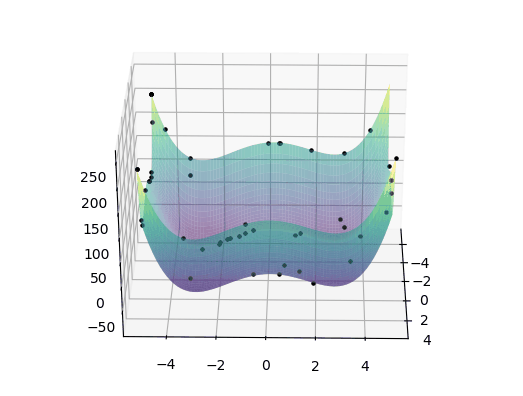

In [ ]:
# Define the fitness function
def fitness_function(features):
    selected_features = np.where(features == 1)[0]
    if not selected_features:
        return -np.inf  # Penalize if no features are selected

    # Train XGBoost model using selected features
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X_train.iloc[:, selected_features], y_train)

    # Evaluate model on test set
    y_pred = xgb_model.predict(X_val.iloc[:, selected_features])
    mse = mean_squared_error(y_val, y_pred)

    return -mse  # Negative MSE to maximize fitness

# Initialize the optimizer
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # PSO hyperparameters
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=X_train.shape[1], options=options)

# Perform optimization
cost, pos = optimizer.optimize(fitness_function, iters=1000)

# Get the best features
best_features = np.round(pos).astype(bool)
selected_column_names = X.columns[best_features]

# Define ANSI escape codes for bold text
bold = "\033[1m"
reset = "\033[0m"
color_red = "\033[91m"
print(f"Selected column names: {bold}{color_red}{selected_column_names.values}{reset}")

2024-04-18 20:59:12,808 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1000<ipython-input-7-e3bbf7aca484>:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not selected_features:
pyswarms.single.global_best:   0%|          |0/1000, best_cost=-inf/usr/local/lib/python3.10/dist-packages/pyswarms/single/global_best.py:229: RuntimeWarning: invalid value encountered in scalar subtract
  np.abs(self.swarm.best_cost - best_cost_yet_found)
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-inf
2024-04-18 20:59:14,850 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -inf, best pos: [0.78732119 0.98897163 0.83162267 0.79255206 0.26920225 0.85501492]


Selected column names: ['time' 'tsunami' 'significance' 'longitude' 'depth']


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standard Scaling the data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train[selected_column_names])
scaled_X_val = scaler.fit_transform(X_val[selected_column_names])
scaled_X_test = scaler.fit_transform(X_test[selected_column_names])

# Reshaping the scaled_X_train, scaled_X_val. scaled_X_test
scaled_X_train_reshaped = scaled_X_train.reshape(scaled_X_train.shape[0], scaled_X_train.shape[1], 1)
scaled_X_val_reshaped = scaled_X_val.reshape(scaled_X_val.shape[0], scaled_X_val.shape[1], 1)
scaled_X_test_reshaped = scaled_X_test.reshape(scaled_X_test.shape[0], scaled_X_test.shape[1], 1)

# XGBoost

In [ ]:
import xgboost as xgb

# Train XGBoost model using selected features
modelXGB = xgb.XGBRegressor()
modelXGB.fit(scaled_X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Validation Set
y_pred_val_xgb = modelXGB.predict(scaled_X_val)

# Calculating R-squared score
r2_val_xgb = r2_score(y_val, y_pred_val_xgb)
print("R-squared Score for Validation Set:", r2_val_xgb)

# Calculating Mean Absolute Error (MAE)
mae_val_xgb = mean_absolute_error(y_val, y_pred_val_xgb)
print("Mean Absolute Error (MAE) for Validation Set:", mae_val_xgb)

# Calculating Mean Squared Error (RMSE)
mse_val_xgb = mean_squared_error(y_val, y_pred_val_xgb)
print("Mean Squared Error (MSE) for Validation Set:", mse_val_xgb)

# Calculating Root Mean Squared Error (RMSE)
rmse_val_xgb = sqrt(mean_squared_error(y_val, y_pred_val_xgb))
print("Root Mean Squared Error (RMSE) for Validation Set:", rmse_val_xgb)

R-squared Score for Validation Set: 0.9972801115201336
Mean Absolute Error (MAE) for Validation Set: 0.03879803771027794
Mean Squared Error (MSE) for Validation Set: 0.003661818171632731
Root Mean Squared Error (RMSE) for Validation Set: 0.06051295870830256


In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Test Set
y_pred_test_xgb = modelXGB.predict(scaled_X_test)

# Calculating R-squared score
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)
print("R-squared score for Test Set:", r2_test_xgb)

# Calculating Mean Absolute Error (MAE)
mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
print("Mean Absolute Error (MAE) for Test Set:", mae_test_xgb)

# Calculating Mean Squared Error (RMSE)
mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
print("Mean Squared Error (MSE) for Test Set:", mse_test_xgb)

# Calculating Root Mean Squared Error (RMSE)
rmse_test_xgb = sqrt(mean_squared_error(y_test, y_pred_test_xgb))
print("Root Mean Squared Error (RMSE) for Test Set:", rmse_test_xgb)

R-squared score for Test Set: 0.9949272241413649
Mean Absolute Error (MAE) for Test Set: 0.021076848969000035
Mean Squared Error (MSE) for Test Set: 0.006703965662633686
Root Mean Squared Error (RMSE) for Test Set: 0.0818777482753018


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model using selected features
modelRF = RandomForestRegressor(random_state=42)
modelRF.fit(scaled_X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Validation Set
y_pred_val_rf = modelRF.predict(scaled_X_val)

# Calculating R-squared score
r2_val_rf = r2_score(y_val, y_pred_val_rf)
print("R-squared Score for Validation Set:", r2_val_rf)

# Calculating Mean Absolute Error (MAE)
mae_val_rf = mean_absolute_error(y_val, y_pred_val_rf)
print("Mean Absolute Error (MAE) for Validation Set:", mae_val_rf)

# Calculating Mean Squared Error (RMSE)
mse_val_rf = mean_squared_error(y_val, y_pred_val_rf)
print("Mean Squared Error (MSE) for Validation Set:", mse_val_rf)

# Calculating Root Mean Squared Error (RMSE)
rmse_val_rf = sqrt(mean_squared_error(y_val, y_pred_val_rf))
print("Root Mean Squared Error (RMSE) for Validation Set:", rmse_val_rf)

R-squared Score for Validation Set: 0.9998089712404715
Mean Absolute Error (MAE) for Validation Set: 0.0051518953507230176
Mean Squared Error (MSE) for Validation Set: 0.00025718428829850457
Root Mean Squared Error (RMSE) for Validation Set: 0.016036966305960257


In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Test Set
y_pred_test_rf = modelRF.predict(scaled_X_test)

# Calculating R-squared score
r2_test_rf = r2_score(y_test, y_pred_test_rf)
print("R-squared score for Test Set:", r2_test_rf)

# Calculating Mean Absolute Error (MAE)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
print("Mean Absolute Error (MAE) for Test Set:", mae_test_rf)

# Calculating Mean Squared Error (RMSE)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
print("Mean Squared Error (MSE) for Test Set:", mse_test_rf)

# Calculating Root Mean Squared Error (RMSE)
rmse_test_rf = sqrt(mean_squared_error(y_test, y_pred_test_rf))
print("Root Mean Squared Error (RMSE) for Test Set:", rmse_test_rf)

R-squared score for Test Set: 0.9956300701019336
Mean Absolute Error (MAE) for Test Set: 0.017890930297859698
Mean Squared Error (MSE) for Test Set: 0.005775114217767891
Root Mean Squared Error (RMSE) for Test Set: 0.07599417226187737


# KNN

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Define the KNN model
gridkNN = KNeighborsRegressor()

# Define the hyperparameters grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']  # Use both Euclidean and Manhattan distances
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gridkNN, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(scaled_X_train, y_train)

# Get the best model
modelkNN = grid_search.best_estimator_

# Print the best parameters found by grid search
print("Best parameters:", grid_search.best_params_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Validation Set
y_pred_val_knn = modelkNN.predict(scaled_X_val)

# Calculating R-squared score
r2_val_knn = r2_score(y_val, y_pred_val_knn)
print("R-squared Score for Validation Set:", r2_val_knn)

# Calculating Mean Absolute Error (MAE)
mae_val_knn = mean_absolute_error(y_val, y_pred_val_knn)
print("Mean Absolute Error (MAE) for Validation Set:", mae_val_knn)

# Calculating Mean Squared Error (RMSE)
mse_val_knn = mean_squared_error(y_val, y_pred_val_knn)
print("Mean Squared Error (MSE) for Validation Set:", mse_val_knn)

# Calculating Root Mean Squared Error (RMSE)
rmse_val_knn = sqrt(mean_squared_error(y_val, y_pred_val_knn))
print("Root Mean Squared Error (RMSE) for Validation Set:", rmse_val_knn)

R-squared Score for Validation Set: 0.9986665753281765
Mean Absolute Error (MAE) for Validation Set: 0.02002427614106441
Mean Squared Error (MSE) for Validation Set: 0.0017952054762284753
Root Mean Squared Error (RMSE) for Validation Set: 0.042369865190114486


In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Test Set
y_pred_test_knn = modelkNN.predict(scaled_X_test)

# Calculating R-squared score
r2_test_knn = r2_score(y_test, y_pred_test_knn)
print("R-squared score for Test Set:", r2_test_knn)

# Calculating Mean Absolute Error (MAE)
mae_test_knn = mean_absolute_error(y_test, y_pred_test_knn)
print("Mean Absolute Error (MAE) for Test Set:", mae_test_knn)

# Calculating Mean Squared Error (RMSE)
mse_test_knn = mean_squared_error(y_test, y_pred_test_knn)
print("Mean Squared Error (MSE) for Test Set:", mse_test_knn)

# Calculating Root Mean Squared Error (RMSE)
rmse_test_knn = sqrt(mean_squared_error(y_test, y_pred_test_knn))
print("Root Mean Squared Error (RMSE) for Test Set:", rmse_test_knn)

R-squared score for Test Set: 0.9948650286303391
Mean Absolute Error (MAE) for Test Set: 0.024703132423217353
Mean Squared Error (MSE) for Test Set: 0.0067861606150436795
Root Mean Squared Error (RMSE) for Test Set: 0.0823781561765234


# RNN - LSTM

In [ ]:
#Building the RNN
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# Class for LSTM
class RNN_LSTM(Model):
    def __init__(self, input_shape):
        super(RNN_LSTM, self).__init__()
        self.lstm1 = LSTM(units=50, return_sequences=True, input_shape=input_shape)
        self.dropout1 = Dropout(0.2)
        self.lstm2 = LSTM(units=50, return_sequences=True)
        self.dropout2 = Dropout(0.2)
        self.lstm3 = LSTM(units=50, return_sequences=True)
        self.dropout3 = Dropout(0.2)
        self.lstm4 = LSTM(units=50)
        self.dropout4 = Dropout(0.2)
        self.dense_output = Dense(units=1)

    def call(self, inputs):
        x = self.lstm1(inputs)
        x = self.dropout1(x)
        x = self.lstm2(x)
        x = self.dropout2(x)
        x = self.lstm3(x)
        x = self.dropout3(x)
        x = self.lstm4(x)
        x = self.dropout4(x)
        return self.dense_output(x)


# Building the model
modelLSTM = RNN_LSTM(input_shape=(scaled_X_train_reshaped.shape[1], 1))

# Compiling the model
modelLSTM.compile(optimizer='adam', loss='mean_squared_error')

# Training the model using selected features
modelLSTM.fit(scaled_X_train_reshaped, y_train, validation_data=(scaled_X_val_reshaped, y_val), epochs=10, batch_size=32)

Epoch 1/10
4630/4630 [==============================] - 56s 10ms/step - loss: 0.1486 - val_loss: 0.0140
Epoch 2/10
4630/4630 [==============================] - 50s 11ms/step - loss: 0.0383 - val_loss: 0.0051
Epoch 3/10
4630/4630 [==============================] - 48s 10ms/step - loss: 0.0244 - val_loss: 0.0057
Epoch 4/10
4630/4630 [==============================] - 48s 10ms/step - loss: 0.0194 - val_loss: 0.0027
Epoch 5/10
4630/4630 [==============================] - 51s 11ms/step - loss: 0.0165 - val_loss: 0.0019
Epoch 6/10
4630/4630 [==============================] - 51s 11ms/step - loss: 0.0150 - val_loss: 0.0035
Epoch 7/10
4630/4630 [==============================] - 47s 10ms/step - loss: 0.0141 - val_loss: 0.0027
Epoch 8/10
4630/4630 [==============================] - 48s 10ms/step - loss: 0.0136 - val_loss: 0.0024
Epoch 9/10
4630/4630 [==============================] - 50s 11ms/step - loss: 0.0131 - val_loss: 0.0013
Epoch 10/10
4630/4630 [==============================] - 50s 11m

In [ ]:
modelLSTM.summary()

Model: "rnn_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               multiple                  10400     
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 lstm_5 (LSTM)               multiple                  20200     
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 lstm_6 (LSTM)               multiple                  20200     
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 lstm_7 (LSTM)               multiple                  2

In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Validation Set
y_pred_val_lstm = modelLSTM.predict(scaled_X_val_reshaped)

# Calculating R-squared score
r2_val_lstm = r2_score(y_val, y_pred_val_lstm)
print("R-squared Score for Validation Set:", r2_val_lstm)

# Calculating Mean Absolute Error (MAE)
mae_val_lstm = mean_absolute_error(y_val, y_pred_val_lstm)
print("Mean Absolute Error (MAE) for Validation Set:", mae_val_lstm)

# Calculating Mean Squared Error (RMSE)
mse_val_lstm = mean_squared_error(y_val, y_pred_val_lstm)
print("Mean Squared Error (MSE) for Validation Set:", mse_val_lstm)

# Calculating Root Mean Squared Error (RMSE)
rmse_val_lstm = sqrt(mean_squared_error(y_val, y_pred_val_lstm))
print("Root Mean Squared Error (RMSE) for Validation Set:", rmse_val_lstm)

1158/1158 [==============================] - 5s 3ms/step
R-squared Score for Validation Set: 0.99927349245645
Mean Absolute Error (MAE) for Validation Set: 0.01641241457081362
Mean Squared Error (MSE) for Validation Set: 0.0009781057365007033
Root Mean Squared Error (RMSE) for Validation Set: 0.03127468203676423


In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Test Set
y_pred_test_lstm = modelLSTM.predict(scaled_X_test_reshaped)

# Calculating R-squared score
r2_test_lstm = r2_score(y_test, y_pred_test_lstm)
print("R-squared score for Test Set:", r2_test_lstm)

# Calculating Mean Absolute Error (MAE)
mae_test_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
print("Mean Absolute Error (MAE) for Test Set:", mae_test_lstm)

# Calculating Mean Squared Error (RMSE)
mse_test_lstm = mean_squared_error(y_test, y_pred_test_lstm)
print("Mean Squared Error (MSE) for Test Set:", mse_test_lstm)

# Calculating Root Mean Squared Error (RMSE)
rmse_test_lstm = sqrt(mean_squared_error(y_test, y_pred_test_lstm))
print("Root Mean Squared Error (RMSE) for Test Set:", rmse_test_lstm)

1447/1447 [==============================] - 6s 4ms/step
R-squared score for Test Set: 0.995620399124471
Mean Absolute Error (MAE) for Test Set: 0.023804169351689948
Mean Squared Error (MSE) for Test Set: 0.0057878949718639435
Root Mean Squared Error (RMSE) for Test Set: 0.07607821614538517


# RNN - GRU

In [ ]:
#Building the RNN
from keras.models import Model
from keras.layers import Dense, GRU, Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

class RNN_GRU(Model):
    def __init__(self, input_shape):
        super(RNN_GRU, self).__init__()
        self.gru1 = GRU(units=50, return_sequences=True, input_shape=input_shape)
        self.dropout1 = Dropout(0.2)
        self.gru2 = GRU(units=50, return_sequences=True)
        self.dropout2 = Dropout(0.2)
        self.gru3 = GRU(units=50, return_sequences=True)
        self.dropout3 = Dropout(0.2)
        self.gru4 = GRU(units=50)
        self.dropout4 = Dropout(0.2)
        self.dense_output = Dense(units=1)

    def call(self, inputs):
        x = self.gru1(inputs)
        x = self.dropout1(x)
        x = self.gru2(x)
        x = self.dropout2(x)
        x = self.gru3(x)
        x = self.dropout3(x)
        x = self.gru4(x)
        x = self.dropout4(x)
        return self.dense_output(x)

# Building the model
modelGRU = RNN_GRU(input_shape=(scaled_X_train.shape[1], 1))

# Compile the model
modelGRU.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using selected features
modelGRU.fit(scaled_X_train_reshaped, y_train, validation_data=(scaled_X_val_reshaped, y_val), epochs=10, batch_size=32)

Epoch 1/10
4630/4630 [==============================] - 51s 10ms/step - loss: 0.1078 - val_loss: 0.0118
Epoch 2/10
4630/4630 [==============================] - 43s 9ms/step - loss: 0.0317 - val_loss: 0.0057
Epoch 3/10
4630/4630 [==============================] - 44s 9ms/step - loss: 0.0207 - val_loss: 0.0016
Epoch 4/10
4630/4630 [==============================] - 44s 9ms/step - loss: 0.0171 - val_loss: 0.0021
Epoch 5/10
4630/4630 [==============================] - 43s 9ms/step - loss: 0.0152 - val_loss: 0.0021
Epoch 6/10
4630/4630 [==============================] - 42s 9ms/step - loss: 0.0142 - val_loss: 0.0061
Epoch 7/10
4630/4630 [==============================] - 43s 9ms/step - loss: 0.0136 - val_loss: 0.0013
Epoch 8/10
4630/4630 [==============================] - 42s 9ms/step - loss: 0.0132 - val_loss: 0.0020
Epoch 9/10
4630/4630 [==============================] - 45s 10ms/step - loss: 0.0127 - val_loss: 0.0012
Epoch 10/10
4630/4630 [==============================] - 43s 9ms/step -

In [ ]:
modelGRU.summary()

Model: "rnn_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   multiple                  7950      
                                                                 
 dropout_8 (Dropout)         multiple                  0         
                                                                 
 gru_1 (GRU)                 multiple                  15300     
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 gru_2 (GRU)                 multiple                  15300     
                                                                 
 dropout_10 (Dropout)        multiple                  0         
                                                                 
 gru_3 (GRU)                 multiple                  1530

In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Validation Set
y_pred_val_gru = modelGRU.predict(scaled_X_val_reshaped)

# Calculating R-squared score
r2_val_gru = r2_score(y_val, y_pred_val_gru)
print("R-squared Score for Validation Set:", r2_val_gru)

# Calculating Mean Absolute Error (MAE)
mae_val_gru = mean_absolute_error(y_val, y_pred_val_gru)
print("Mean Absolute Error (MAE) for Validation Set:", mae_val_gru)

# Calculating Mean Squared Error (RMSE)
mse_val_gru = mean_squared_error(y_val, y_pred_val_gru)
print("Mean Squared Error (MSE) for Validation Set:", mse_val_gru)

# Calculating Root Mean Squared Error (RMSE)
rmse_val_gru = sqrt(mean_squared_error(y_val, y_pred_val_gru))
print("Root Mean Squared Error (RMSE) for Validation Set:", rmse_val_gru)

1158/1158 [==============================] - 6s 4ms/step
R-squared Score for Validation Set: 0.9989146690139177
Mean Absolute Error (MAE) for Validation Set: 0.026758010088930737
Mean Squared Error (MSE) for Validation Set: 0.001461193999861158
Root Mean Squared Error (RMSE) for Validation Set: 0.03822556735826373


In [ ]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Evaluation of the model on Test Set
y_pred_test_gru = modelGRU.predict(scaled_X_test_reshaped)

# Calculating R-squared score
r2_test_gru = r2_score(y_test, y_pred_test_gru)
print("R-squared score for Test Set:", r2_test_gru)

# Calculating Mean Absolute Error (MAE)
mae_test_gru = mean_absolute_error(y_test, y_pred_test_gru)
print("Mean Absolute Error (MAE) for Test Set:", mae_test_gru)

# Calculating Mean Squared Error (RMSE)
mse_test_gru = mean_squared_error(y_test, y_pred_test_gru)
print("Mean Squared Error (MSE) for Test Set:", mse_test_gru)

# Calculating Root Mean Squared Error (RMSE)
rmse_test_gru = sqrt(mean_squared_error(y_test, y_pred_test_gru))
print("Root Mean Squared Error (RMSE) for Test Set:", rmse_test_gru)

1447/1447 [==============================] - 4s 3ms/step
R-squared score for Test Set: 0.9958852741058124
Mean Absolute Error (MAE) for Test Set: 0.02062038246981796
Mean Squared Error (MSE) for Test Set: 0.005437847418160008
Root Mean Squared Error (RMSE) for Test Set: 0.07374176169688386


# Results and Reporting

In [ ]:
from tabulate import tabulate

# Create a list of lists containing the evaluation metrics for each model
data = [
    ['XGBoost', r2_test_xgb, mae_test_xgb, mse_test_xgb, rmse_test_xgb],
    ['Random Forest', r2_test_rf, mae_test_rf, mse_test_rf, rmse_test_rf],
    ['KNN', r2_test_knn, mae_test_knn, mse_test_knn, rmse_test_knn],
    ['LSTM', r2_test_lstm, mae_test_lstm, mse_test_lstm, rmse_test_lstm],
    ['GRU', r2_test_gru, mae_test_gru, mse_test_gru, rmse_test_gru],
]

# Define the headers for the table
headers = ['Model', 'R-Squared', 'MAE', 'MSE']

# Print the tabular representation
print(tabulate(data, headers=headers, tablefmt='pretty'))


+---------------+--------------------+----------------------+-----------------------+---------------------+
|               |       Model        |      R-Squared       |          MAE          |         MSE         |
+---------------+--------------------+----------------------+-----------------------+---------------------+
|    XGBoost    | 0.9949272241413649 | 0.021076848969000035 | 0.006703965662633686  | 0.0818777482753018  |
| Random Forest | 0.9956300701019336 | 0.017890930297859698 | 0.005775114217767891  | 0.07599417226187737 |
|      KNN      | 0.9948650286303391 | 0.024703132423217353 | 0.0067861606150436795 | 0.0823781561765234  |
|     LSTM      | 0.995620399124471  | 0.023804169351689948 | 0.0057878949718639435 | 0.07607821614538517 |
|      GRU      | 0.9958852741058124 | 0.02062038246981796  | 0.005437847418160008  | 0.07374176169688386 |
+---------------+--------------------+----------------------+-----------------------+---------------------+


In [ ]:
import pandas as pd

# Create a list of lists containing the evaluation metrics for each model
data = [
    ['XGBoost', r2_test_xgb, mae_test_xgb, mse_test_xgb, rmse_test_xgb],
    ['Random Forest', r2_test_rf, mae_test_rf, mse_test_rf, rmse_test_rf],
    ['KNN', r2_test_knn, mae_test_knn, mse_test_knn, rmse_test_knn],
    ['LSTM', r2_test_lstm, mae_test_lstm, mse_test_lstm, rmse_test_lstm],
    ['GRU', r2_test_gru, mae_test_gru, mse_test_gru, rmse_test_gru],
]

# Define the headers for the table
headers = ['Model', 'R-Squared', 'MAE', 'MSE', 'RMSE']

# Create a DataFrame with the evaluation metrics for each model
df = pd.DataFrame(data, columns=headers)

df

Model  R-Squared       MAE       MSE      RMSE
0        XGBoost   0.994927  0.021077  0.006704  0.081878
1  Random Forest   0.995630  0.017891  0.005775  0.075994
2            KNN   0.994865  0.024703  0.006786  0.082378
3           LSTM   0.995620  0.023804  0.005788  0.076078
4            GRU   0.995885  0.020620  0.005438  0.073742

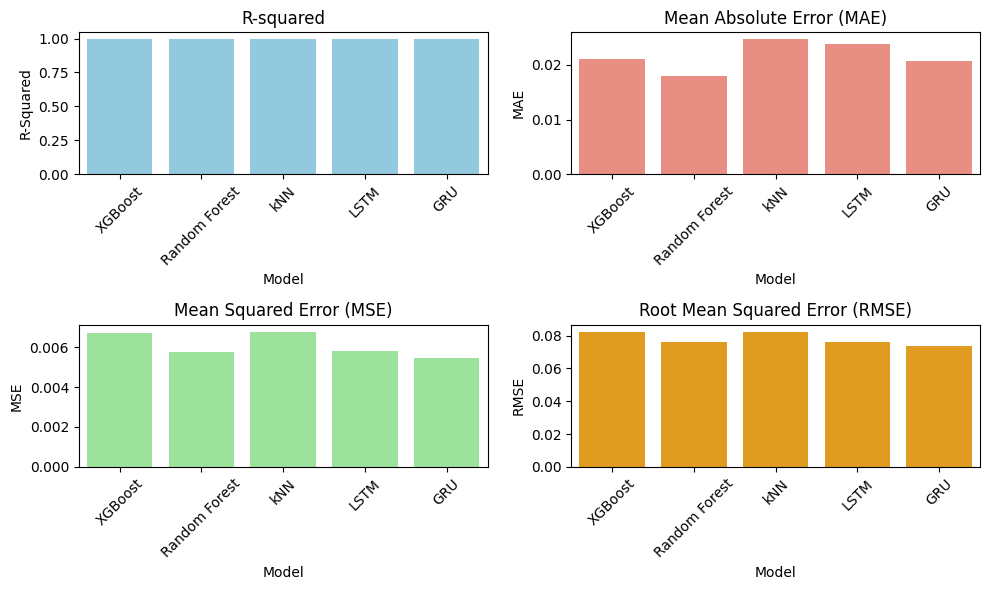

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to store the evaluation metrics of each model
data = {
    'Model': ['XGBoost', 'Random Forest', 'kNN', 'LSTM', 'GRU'],
    'R-Squared': [r2_test_xgb, r2_test_rf, r2_test_knn, r2_test_lstm, r2_test_gru],
    'MAE': [mae_test_xgb, mae_test_rf, mae_test_knn, mae_test_lstm, mae_test_gru],
    'MSE': [mse_test_xgb, mse_test_rf, mse_test_knn, mse_test_lstm, mse_test_gru],
    'RMSE': [rmse_test_xgb, rmse_test_rf, rmse_test_knn, rmse_test_lstm, rmse_test_gru]

}
metrics_df = pd.DataFrame(data)

# Plotting MAE, R-squared, and RMSE for each model
plt.figure(figsize=(10, 6))

# Plot R-Squared
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='R-Squared', data=metrics_df,color='skyblue')
plt.title('R-squared')
plt.xticks(rotation=45)

# Plot MAE
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='MAE', data=metrics_df,color='salmon')
plt.title('Mean Absolute Error (MAE)')
plt.xticks(rotation=45)

# Plot MSE
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='MSE', data=metrics_df, color='lightgreen')
plt.title('Mean Squared Error (MSE)')
plt.xticks(rotation=45)

# Plot RMSE
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='RMSE', data=metrics_df, color='orange')
plt.title('Root Mean Squared Error (RMSE)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
metrics_df.to_csv('out.csv', index=False)

In [ ]:
from joblib import dump

dump(modelXGB, 'modelXGB.joblib')
dump(modelRF, 'modelRF.joblib')
dump(modelkNN, 'modelkNN.joblib')

['modelkNN.joblib']

In [ ]:
modelLSTM_json = modelLSTM.to_json()
with open("modelLSTM.json", "w") as json_file:
    json_file.write(modelLSTM_json)

modelLSTM.save_weights('modelLSTM.h5')

modelGRU_json = modelGRU.to_json()
with open("modelGRU.json", "w") as json_file:
    json_file.write(modelLSTM_json)

modelGRU.save_weights('modelGRU.h5')